### Flow 

* Descriptive Statistic
* Text Data Cleaning  
* Affin sentiment or Rating conversion to Positive Negative Neutral
* Visualization - Word Cloud // Term Frequency -> to understand the attribute
* CountVectorizer / TFIDF -> Vectors
* Handling imbalance Data set -> SMOTE
* Split into Train and Test 
* Model Building & Evaluation

In [ ]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install afinn

  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=0a5afc3fd1602b90a2097c805c6548b30775313f1b8aac5e6ab58a86677102d1
  Stored in directory: c:\users\onkar gaikwad\appdata\local\pip\cache\wheels\79\91\ee\8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pylab as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 15})

# Text Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from afinn import Afinn
from collections import Counter

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Model Validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

#Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

#Model Accuracy
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report

# To save & load models
from pickle import dump
from pickle import load

#Warnings
import warnings
warnings.filterwarnings("ignore")

### Descriptive Statistics

In [ ]:
# Custom Function to divide the rating into two class problem (howevere it is is primitive technique)
def map_sentiment(rating):
    if rating <= 2:
        return 0
    else:
        return 1

In [ ]:
# loading the extracted dataset
df = pd.read_csv("hotel_review.csv")



# sentiment maped into 2 class 1=Positive reviews 0=Negtaive reviews
df['Sentiment'] = [map_sentiment(x) for x in df['Rating']]
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [ ]:
# no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     20491 non-null  object
 1   Rating     20491 non-null  int64 
 2   Sentiment  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


In [ ]:
# No Duplicate values
df.duplicated().value_counts()

False    20491
dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

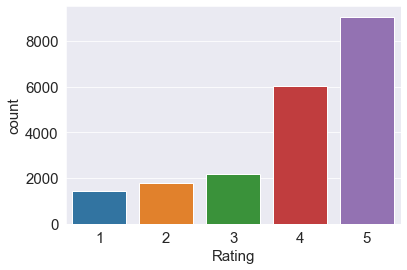

In [ ]:
# Most of the rating are in 4 and 5 
sns.countplot(df['Rating'])

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

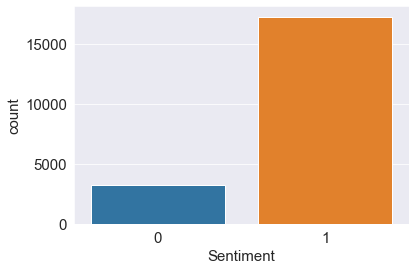

In [ ]:
# 1 = Positive 0 = Negative
sns.countplot(df['Sentiment'])

### Text Data Cleaning

In [ ]:
#Lemmatization
wordnet=WordNetLemmatizer()

#Stop word
stop_words=stopwords.words('english')

nlp=spacy.load('en_core_web_sm')

In [ ]:
# Varibale created for words which are not included in the stopwords
not_stopwords = ("aren", "aren't", "couldn", "couldn't", "didn", "didn't",
                 "doesn", "doesn't", "don", "don't", "hadn", "hadn't", "hasn",
                 "hasn't", "haven", "haven't", "isn", "isn't", "mustn",
                 "mustn't", "no", "not", "only", "shouldn", "shouldn't",
                 "should've", "wasn", "wasn't", "weren", "weren't", "will",
                 "wouldn", "wouldn't", "won't", "very")
stop_words_ = [words for words in stop_words if words not in not_stopwords]

# Additional words added in the stop word list
stop_words_.append("I")
stop_words_.append("the")
stop_words_.append("s")
print(stop_words_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can'

In [ ]:
corpus = []
for i in range(0, len(df)):
    # Removal of puntuations
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])

    # Converting Text to Lower case
    review = review.lower()

    # Spliting each words - eg ['I','was','happy']
    review = review.split()

    # Applying Lemmitization for the words eg: Argument -> Argue - Using Spacy Library
    review = nlp(' '.join(review))
    review = [token.lemma_ for token in review]

    # Removal of stop words
    review = [word for word in review if word not in stop_words_]

    # Joining the words in sentences
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
pd.DataFrame(corpus).head()

,0
0,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice room not experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...
4,great stay great stay go seahawk game awesome ...


In [ ]:
# cleaned review added to the data frame
df['Cleaned_Review'] = corpus

In [ ]:
# Finding total words in cleaned review
clean_review_words = " ".join(df['Cleaned_Review'])
clean_review_words = clean_review_words.split()

# total number of words present in cleaned reviews
len(clean_review_words)

2072877

<AxesSubplot:xlabel='Word_count_clean_review', ylabel='Count'>

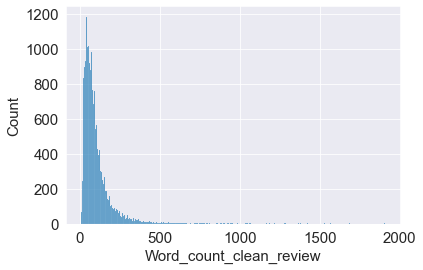

In [ ]:
# Number of words in the cleaned Review
df['Word_count_clean_review'] = pd.Series(
    [len(item.split()) for item in df['Cleaned_Review']])

# most of the cleaned review have 20 to 40 words
sns.histplot(df['Word_count_clean_review'])

In [ ]:
# finding frequency of all words
all_words = len(clean_review_words)
print('Total words in clean review is {}'.format(all_words))

word_dist = nltk.FreqDist(clean_review_words)

# Creating dataframe for word frequency
freq_data_all = pd.DataFrame(word_dist.most_common(all_words),
                             columns=['Word', 'Frequency'])

# Percentage of word frequency
freq_data_all['percentFreq_all'] = (freq_data_all.Frequency /
                                    freq_data_all.Frequency.sum()) * 100

print('No of unique words {}'.format(len(freq_data_all)))
print(freq_data_all[0:10])

Total words in clean review is 2072877
No of unique words 42712
    Word  Frequency  percentFreq_all
0  hotel      53956         2.602952
1   room      47773         2.304671
2    not      34323         1.655815
3   stay      28234         1.362068
4   good      22196         1.070782
5  great      21625         1.043236
6      n      19110         0.921907
7  staff      16795         0.810227
8  night      14311         0.690393
9    day      13411         0.646975


In [ ]:
# words which are used only once 
(freq_data_all['Frequency']==1).value_counts() 

True     21822
False    20890
Name: Frequency, dtype: int64

### Affin Sentiment 

In [ ]:
afn=Afinn()

In [ ]:
# Affin Sentiment Score
score = [afn.score(item) for item in df['Cleaned_Review']]

# Positive review = 1
# Negative review = 0

# Affin Sentiment Making it a two class classification problem
Affin_sentiment = [1 if score > 0 else 0 for score in score]

In [ ]:
# Affin Sentiment & Score added to the data frame
df['Affin_score'] = score
df['Affin_sentiment'] = Affin_sentiment

In [ ]:
# viewing only the negative reviews
df[df['Affin_sentiment'] == 0]['Cleaned_Review']

42       warwick bad good review warwick shock staff qu...
44       austin power decor familiar hotel seattlewhere...
65       hate inn terrible room service horrible staff ...
76       stay clear internet reservation friday rang ho...
88       bad hotel experience book nonsmoke room online...
                               ...                        
20421    bad sleep hip tooooo hip nite club building ca...
20465    not stay hotel bring group february bad hotel ...
20467    return la concha nightmare surprising hotel re...
20484    deceptive staff deceptive desk staff claim not...
20489    hotel theft ruin vacation hotel open sept gues...
Name: Cleaned_Review, Length: 1692, dtype: object

In [ ]:
df.head()

,Review,Rating,Sentiment,Cleaned_Review,Word_count_clean_review,Affin_score,Affin_sentiment
0,nice hotel expensive parking got good deal sta...,4,1,nice hotel expensive parking get good deal sta...,83,26.0,1
1,ok nothing special charge diamond member hilto...,2,0,ok nothing special charge diamond member hilto...,243,29.0,1
2,nice rooms not 4* experience hotel monaco seat...,3,1,nice room not experience hotel monaco seattle ...,205,18.0,1
3,"unique, great stay, wonderful time hotel monac...",5,1,unique great stay wonderful time hotel monaco ...,87,38.0,1
4,"great stay great stay, went seahawk game aweso...",5,1,great stay great stay go seahawk game awesome ...,181,33.0,1


<AxesSubplot:xlabel='Affin_score', ylabel='Density'>

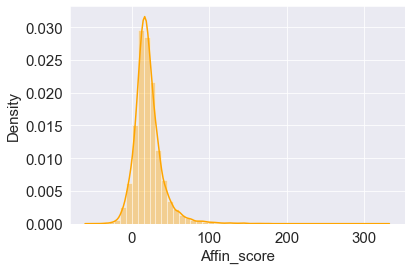

In [ ]:
# Affin score visualization
sns.distplot(df['Affin_score'], color='orange')

Class: 1, Number: 18799, Percentage 375.98
Class: 0, Number: 1692, Percentage 33.84


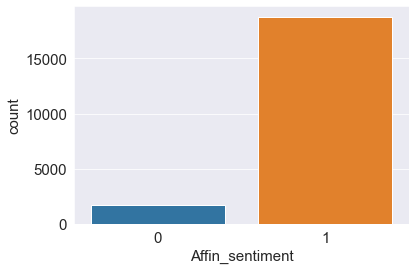

In [ ]:
sns.countplot(df['Affin_sentiment'])
counter = Counter(df['Affin_sentiment'])
counter.items()

# Percentage of Data as per Affin Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / 5000 * 100
    print("Class: {}, Number: {}, Percentage {}".format(
        k, v, np.round(per, 2)))

### Visualization

#### Word cloud for Entire Reviews 

In [ ]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(corpus))

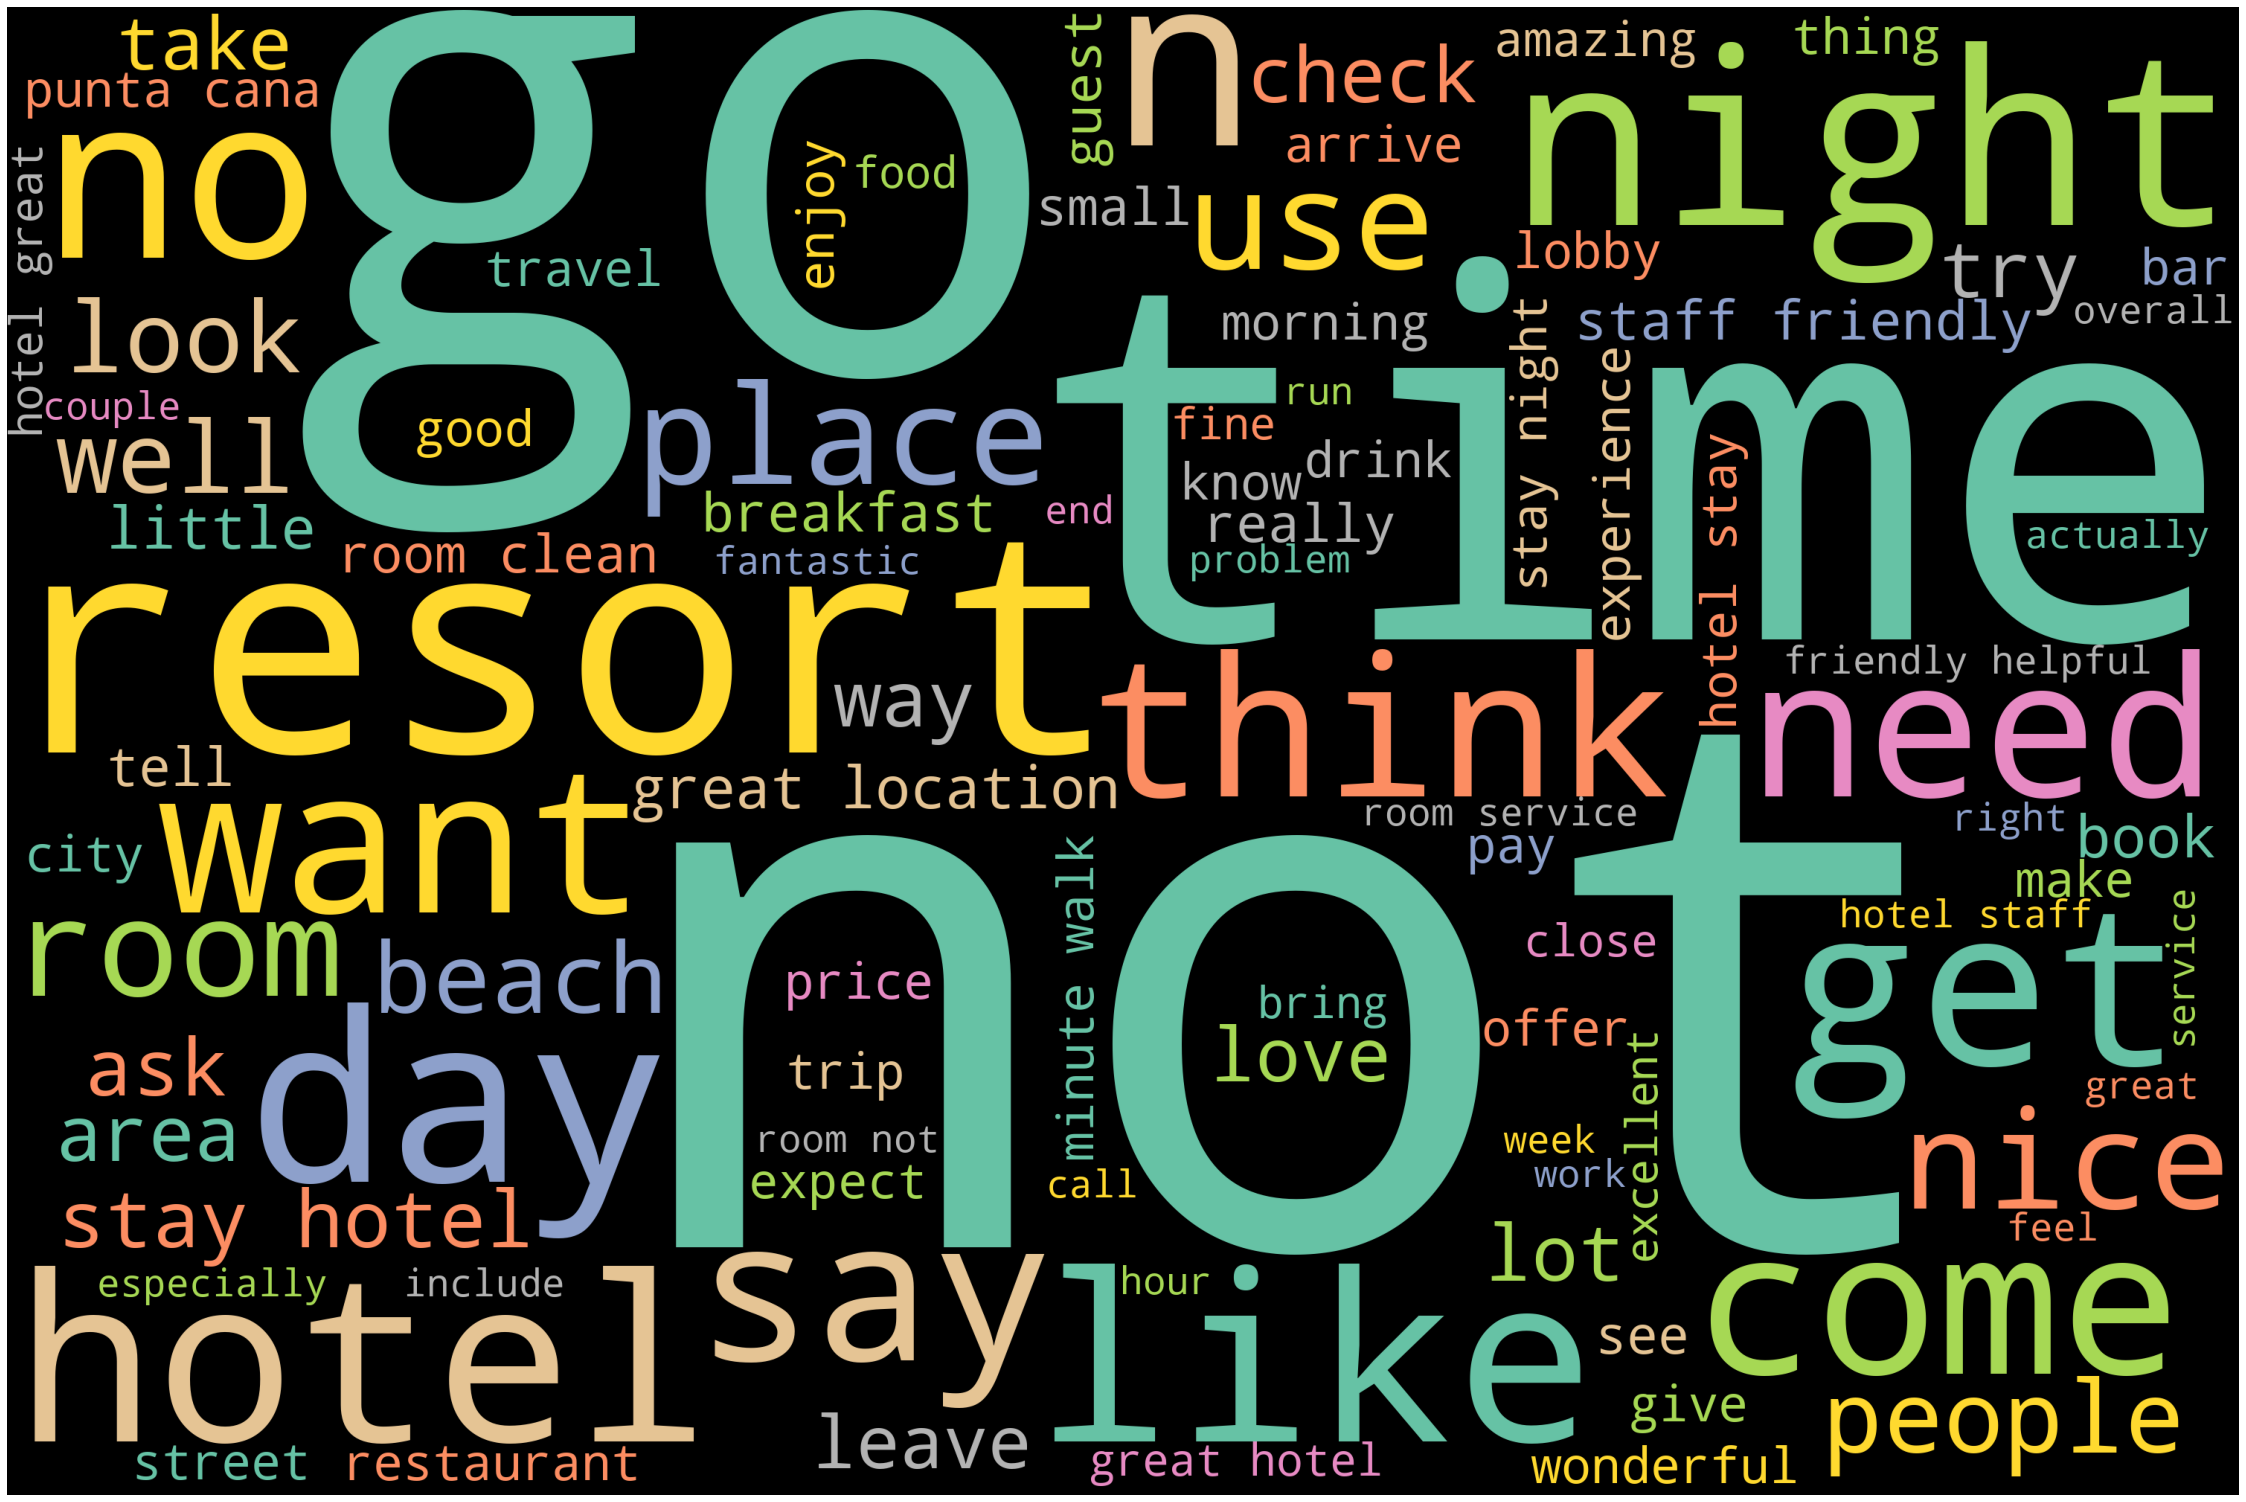

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Word Cloud for Positive Reviews 

In [ ]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(df[df['Affin_sentiment'] == 1]['Cleaned_Review']))

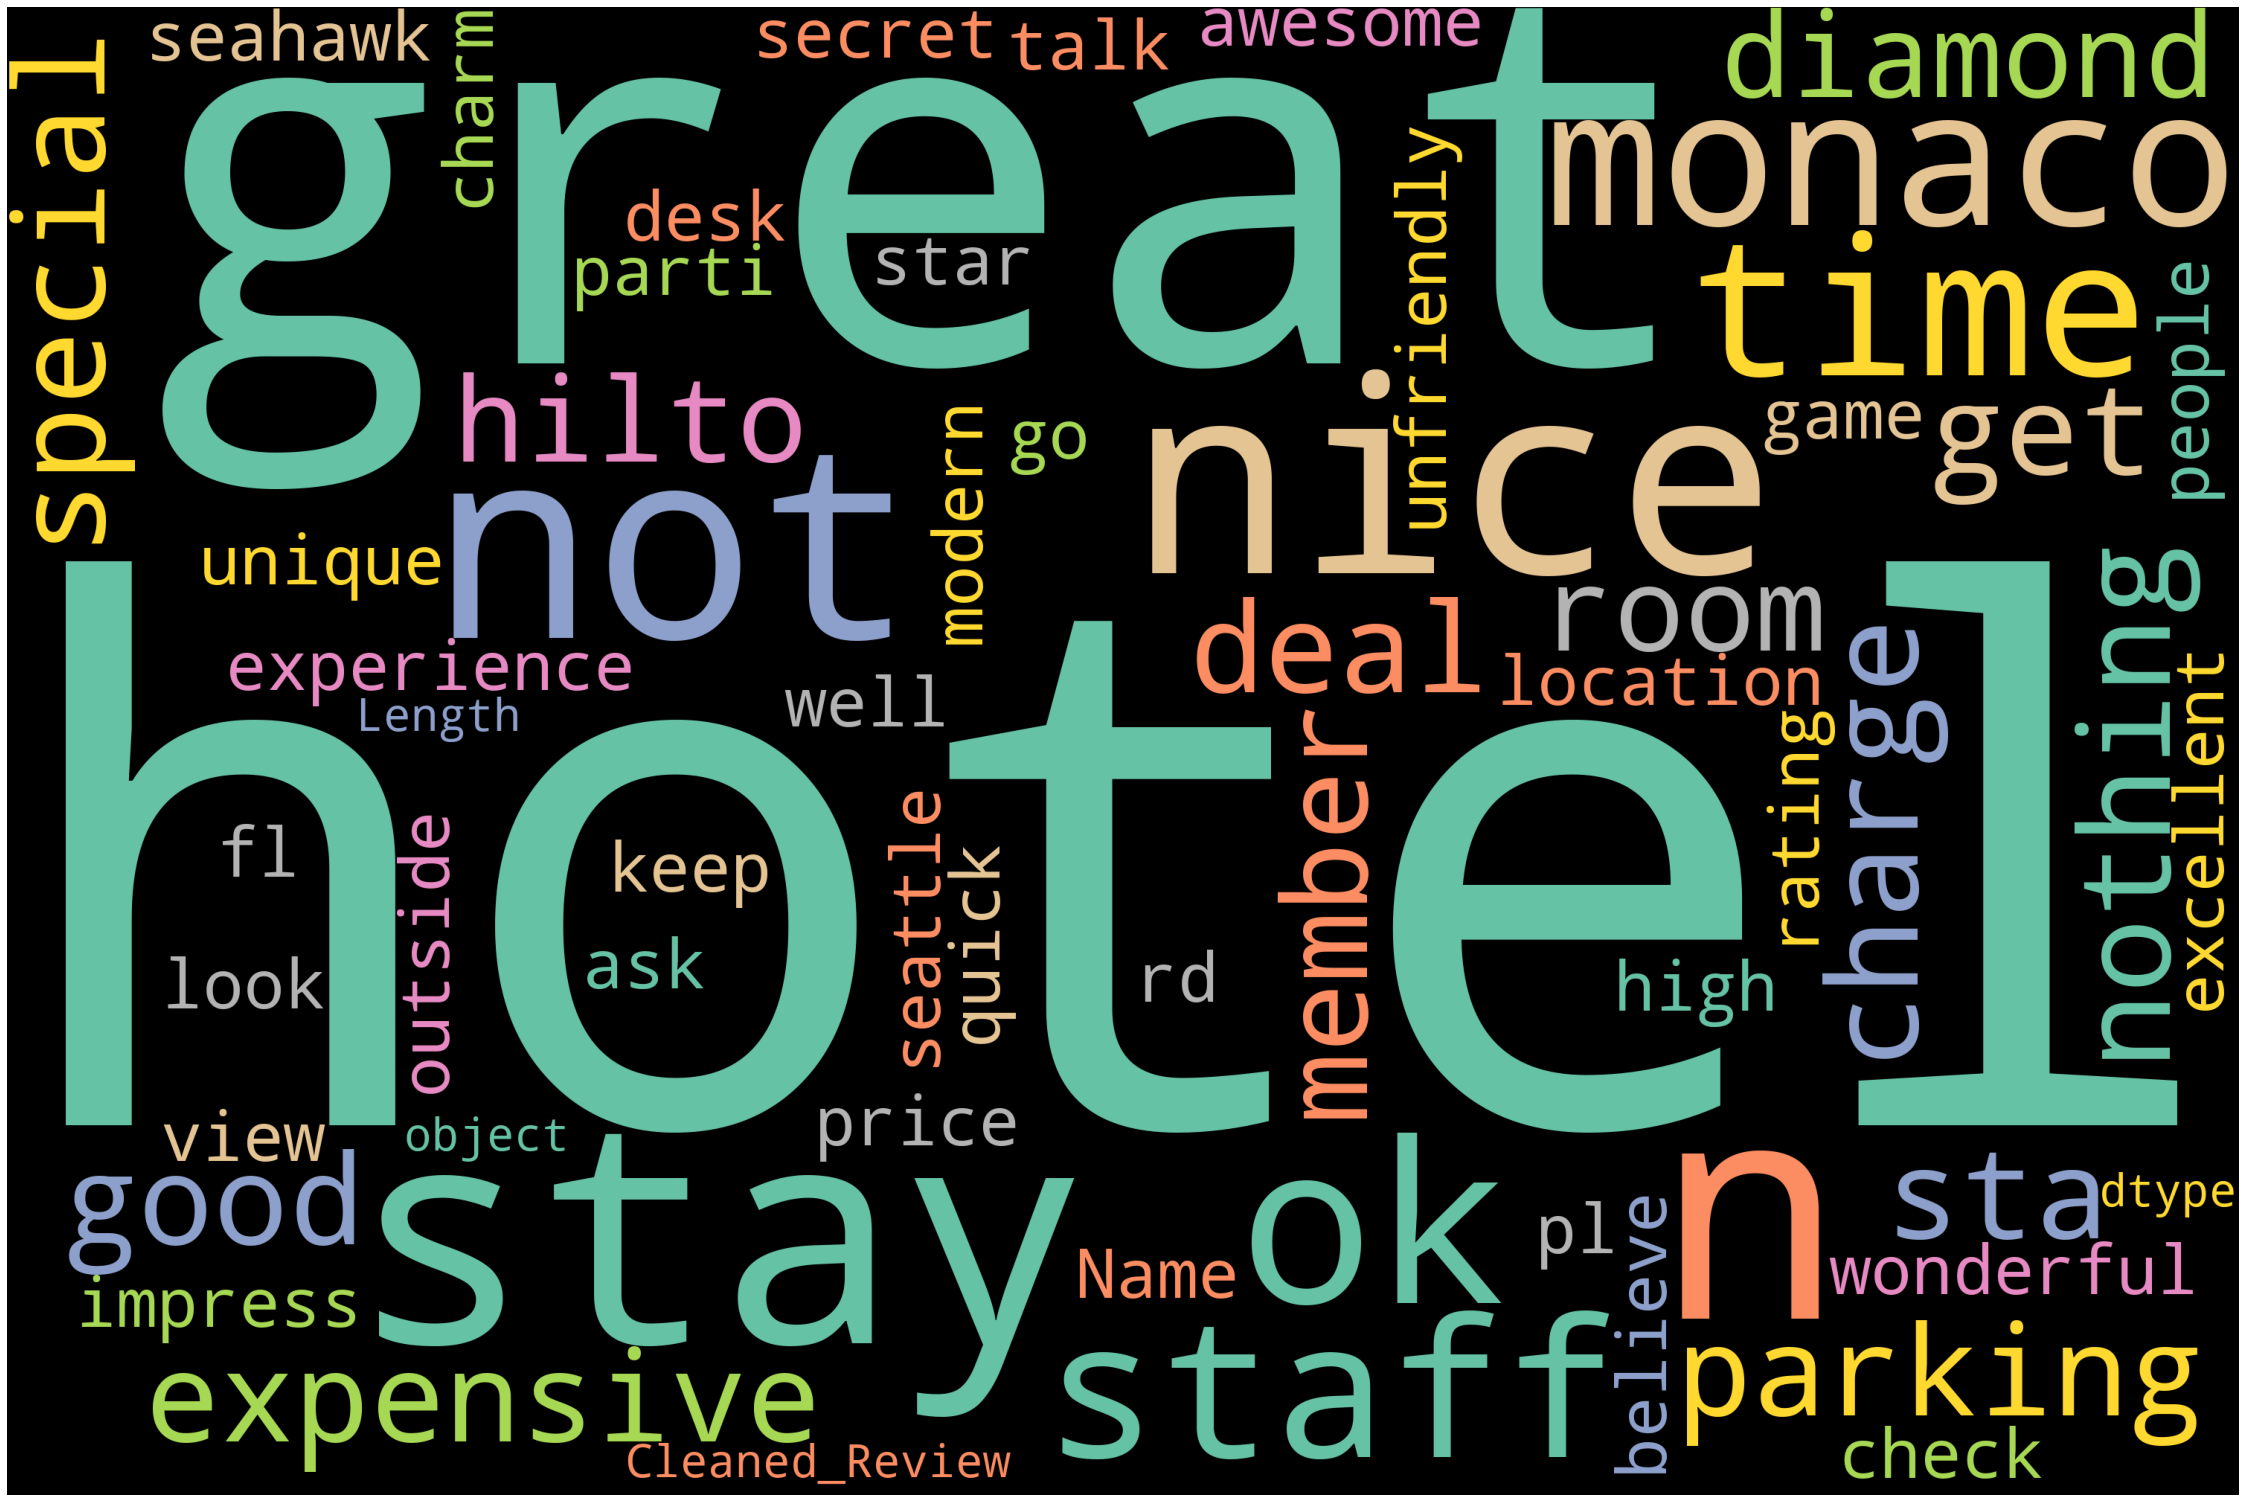

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Word Cloud for Negative Reviews

In [ ]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='Black',
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100,
    random_state=42,
).generate(str(df[df['Affin_sentiment'] == 0]['Cleaned_Review']))

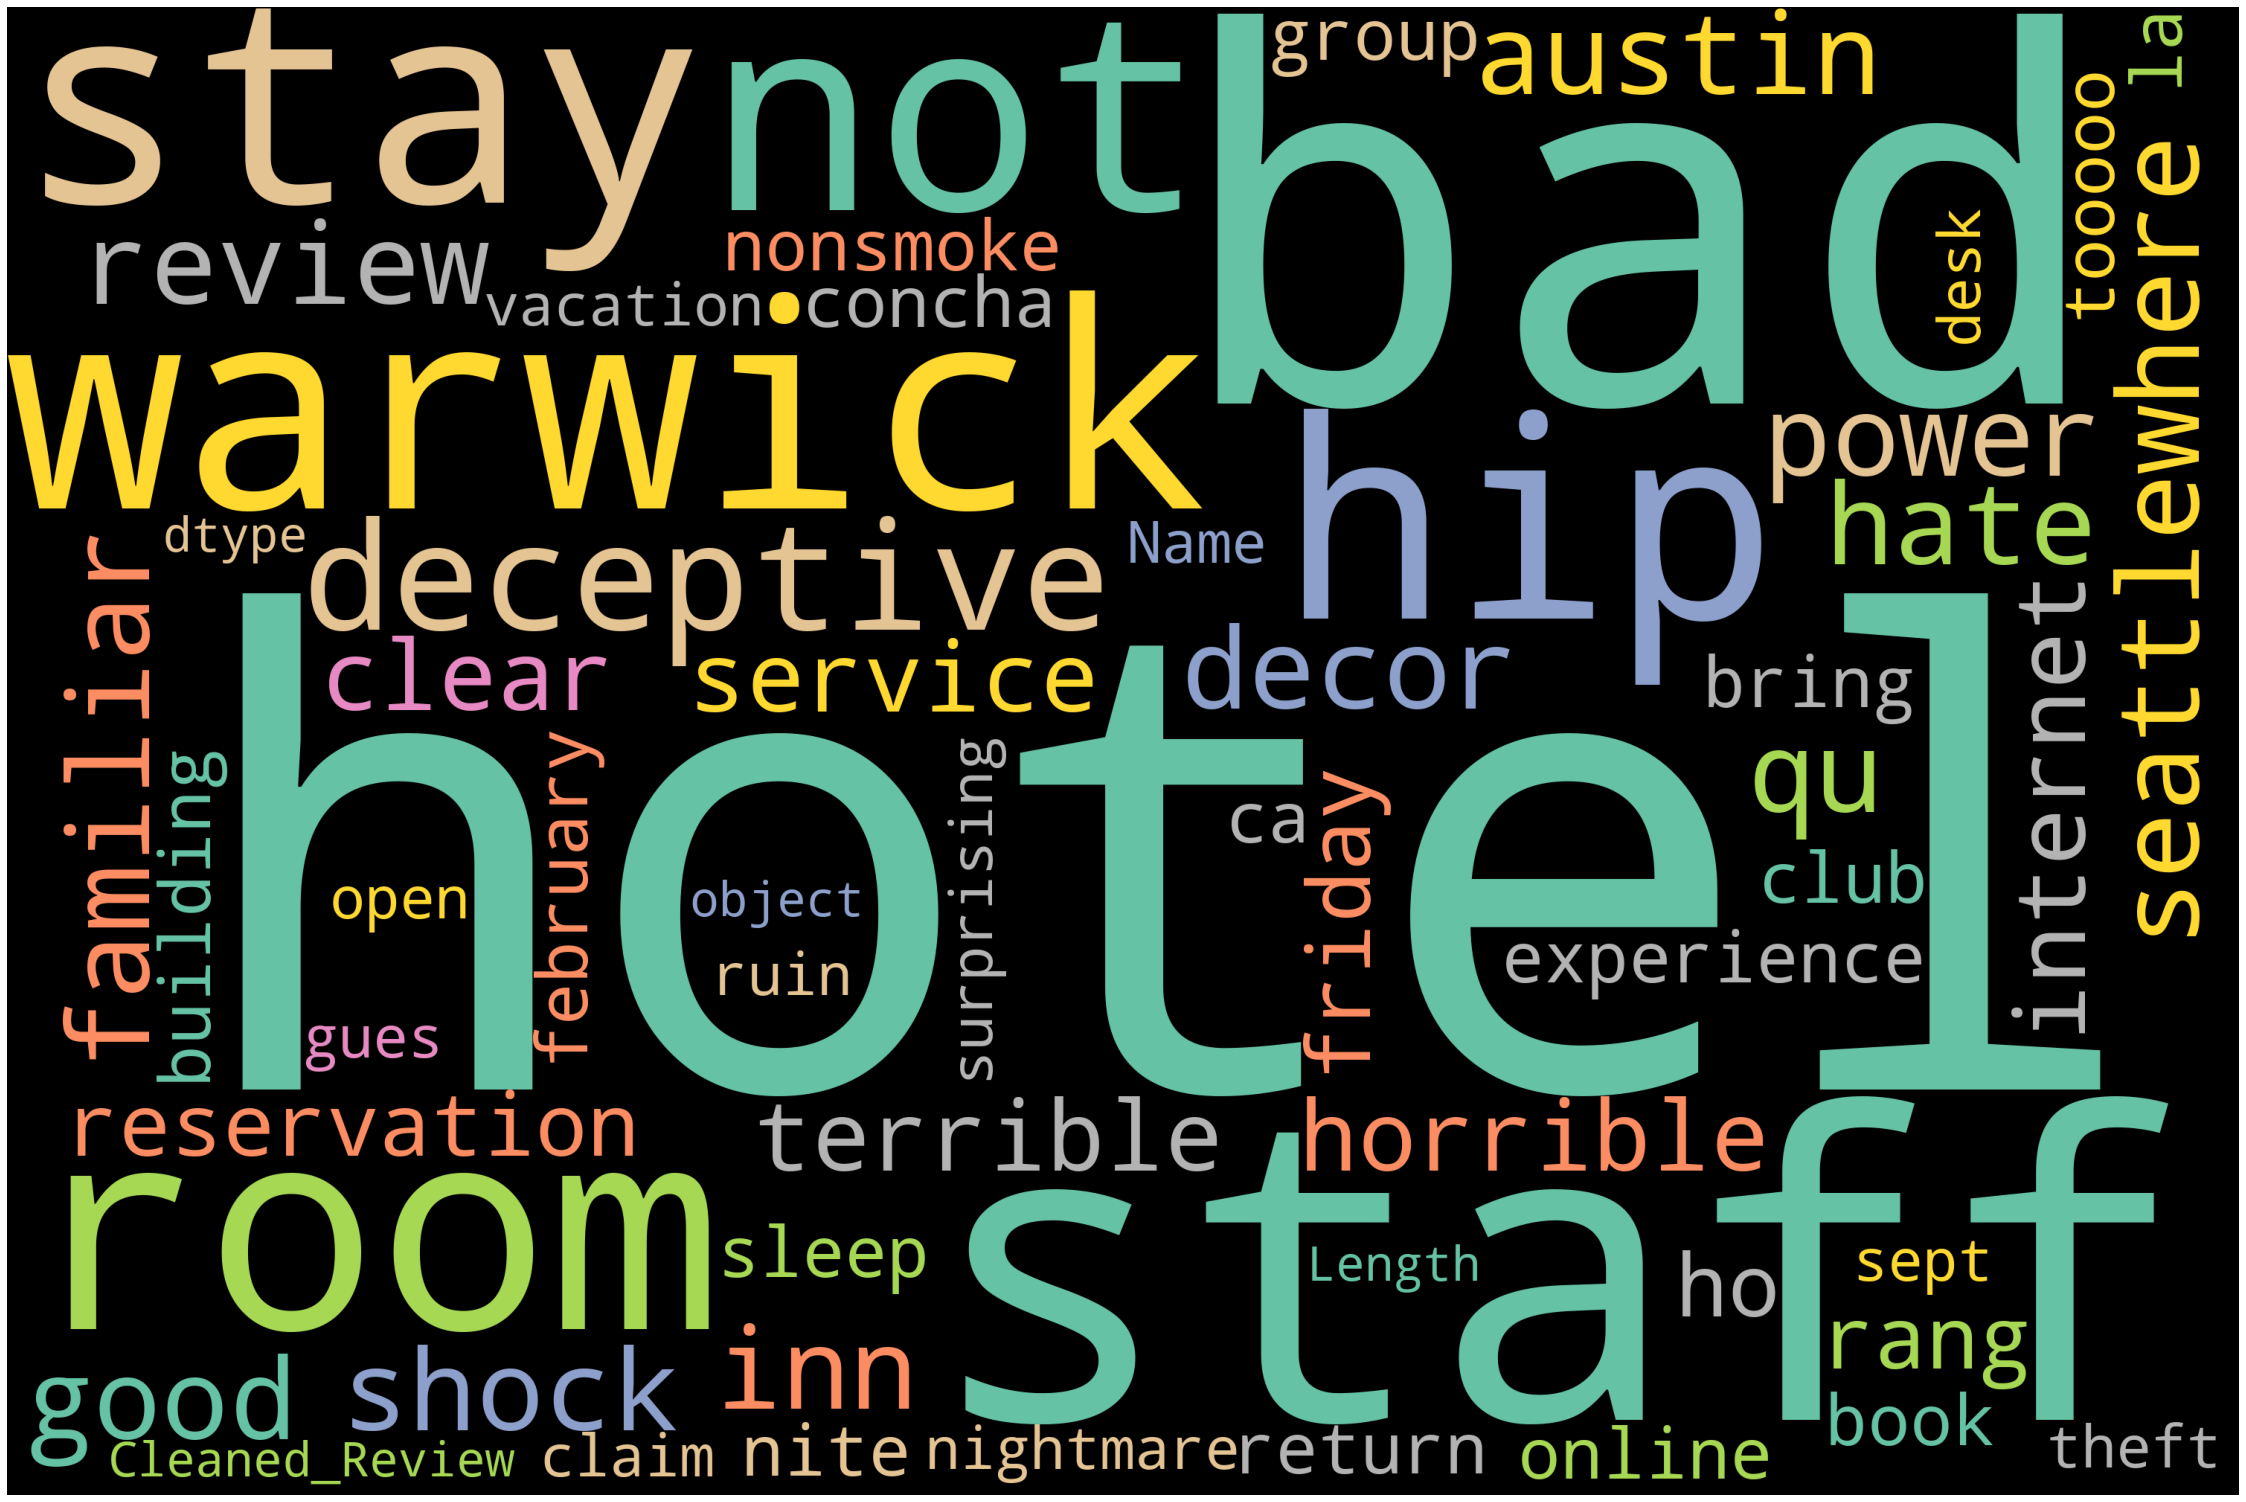

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Term Frequency with Count Vetorizer

In [ ]:
# Stop word
stop_words_keywords = stopwords.words('english')

# special additioanl stop words added for keyword extraction
stop_words_keywords.extend([
    "will", "always", "go", "one", "very", "good", "only", "mr", "lot", "two",
    "th", "etc", "don", "due", "didn", "since", "nt", "ms", "ok", "almost",
    "put", "pm", "hyatt", "grand", "till", "add", "let", "hotel", "able",
    "per", "st", "couldn", "yet", "par", "hi", "well", "would", "I", "the",
    "s", "also", "great", "get", "like", "take", "thank"
])

In [ ]:
# find the most frequent words in the data, extracting information about its content and topics.

stops = set(stopwords.words('english') + ['com'])
co = CountVectorizer(stop_words=stop_words_keywords)
counts = co.fit_transform(corpus)
most_freq_terms = pd.DataFrame(counts.sum(axis=0),
                               columns=co.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)

<AxesSubplot:title={'center':'Unigram Frequency'}>

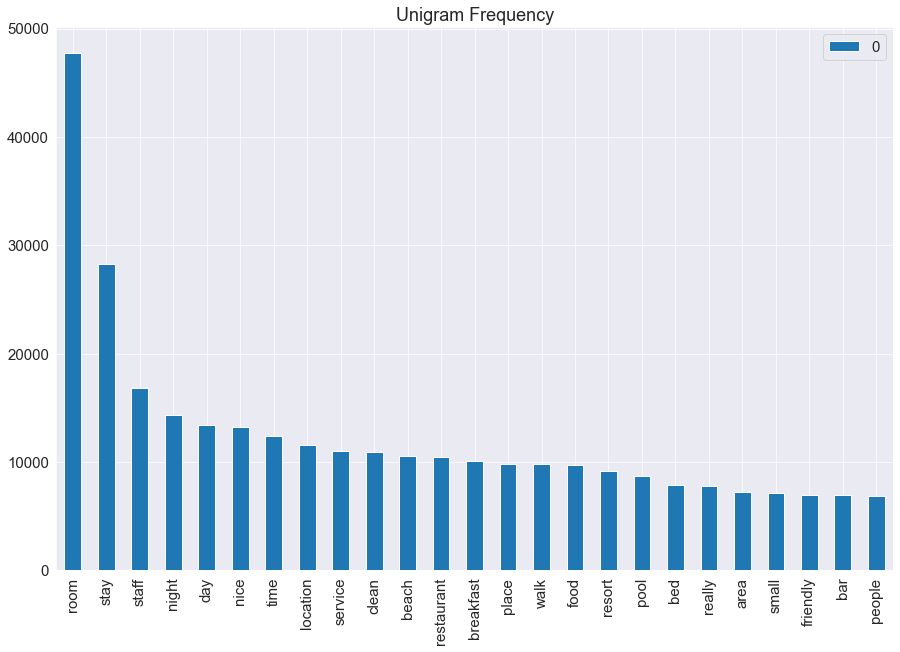

In [ ]:
most_freq_terms.plot(kind='bar', title='Unigram Frequency', figsize=(15, 10))

In [ ]:
# Now we can check for frequent bi-grams:
co = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
bi_grams = pd.DataFrame(counts1.sum(axis=0),
                        columns=co.get_feature_names()).T.sort_values(
                            0, ascending=False).head(25)

<AxesSubplot:title={'center':'bi-grams'}>

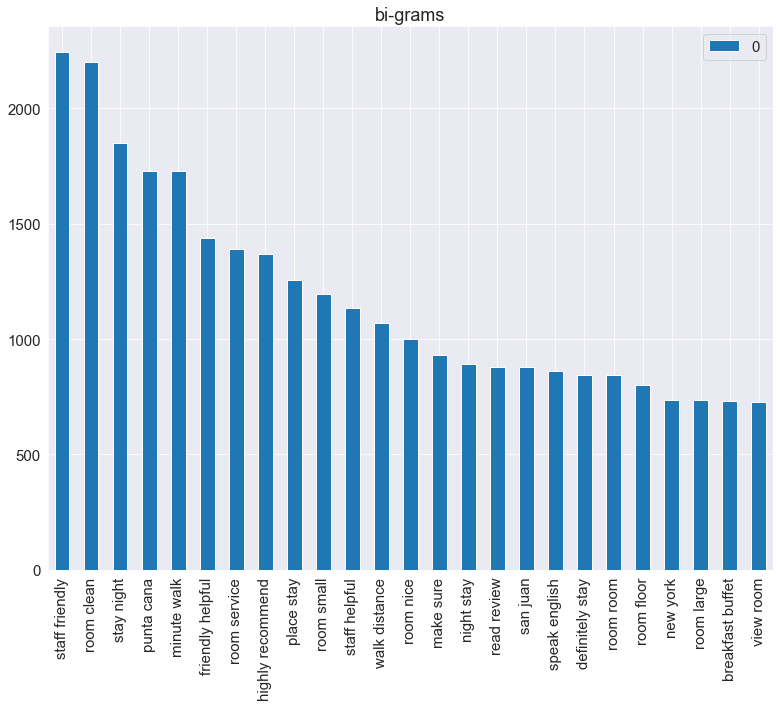

In [ ]:
bi_grams.plot(kind='bar', title='bi-grams', figsize=(13, 10))

In [ ]:
# Now we can check for frequent tri-grams:
co = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
tri_grams = pd.DataFrame(counts1.sum(axis=0),
                         columns=co.get_feature_names()).T.sort_values(
                             0, ascending=False).head(25)

<AxesSubplot:title={'center':'tri-grams'}>

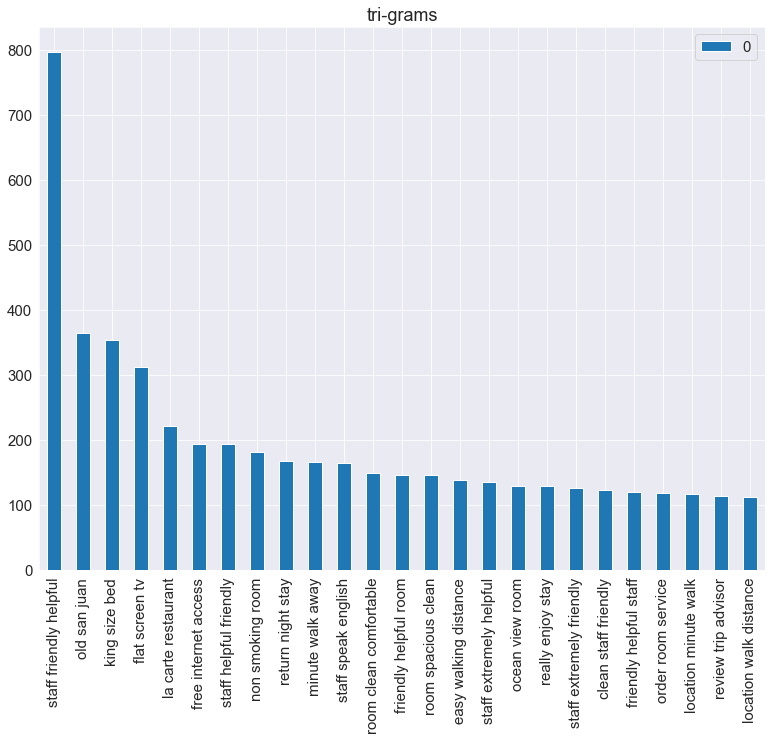

In [ ]:
tri_grams.plot(kind='bar', title='tri-grams', figsize=(13, 10))

#### Term Frequency with TFIDF

In [ ]:
# Converting text into vectors by TFIDF
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,1))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),
                               columns=tfidf2.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)


<AxesSubplot:title={'center':'most frequent terms & their frequency'}>

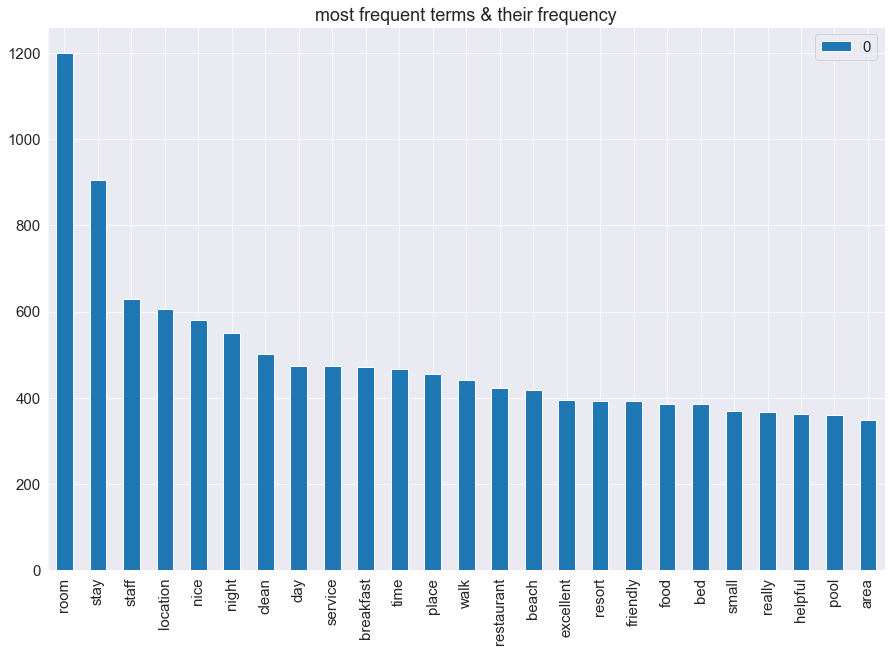

In [ ]:
most_freq_terms.plot(kind='bar',
                     title='most frequent terms & their frequency',
                     figsize=(15, 10))

In [ ]:
# Now we can check for frequent bi-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(2, 2))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)

<AxesSubplot:title={'center':'Bi-Gram'}>

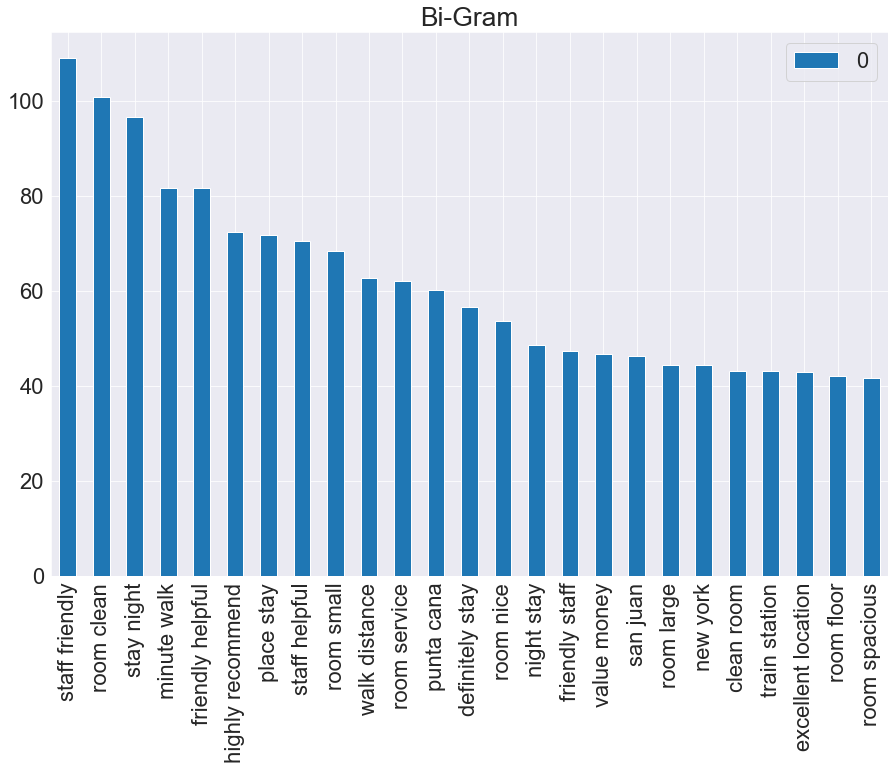

In [ ]:
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Bi-Gram', figsize=(15, 10))

In [ ]:
# Now we can check for frequent tri-grams:

tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(3, 3))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)

<AxesSubplot:title={'center':'Tri-Gram'}>

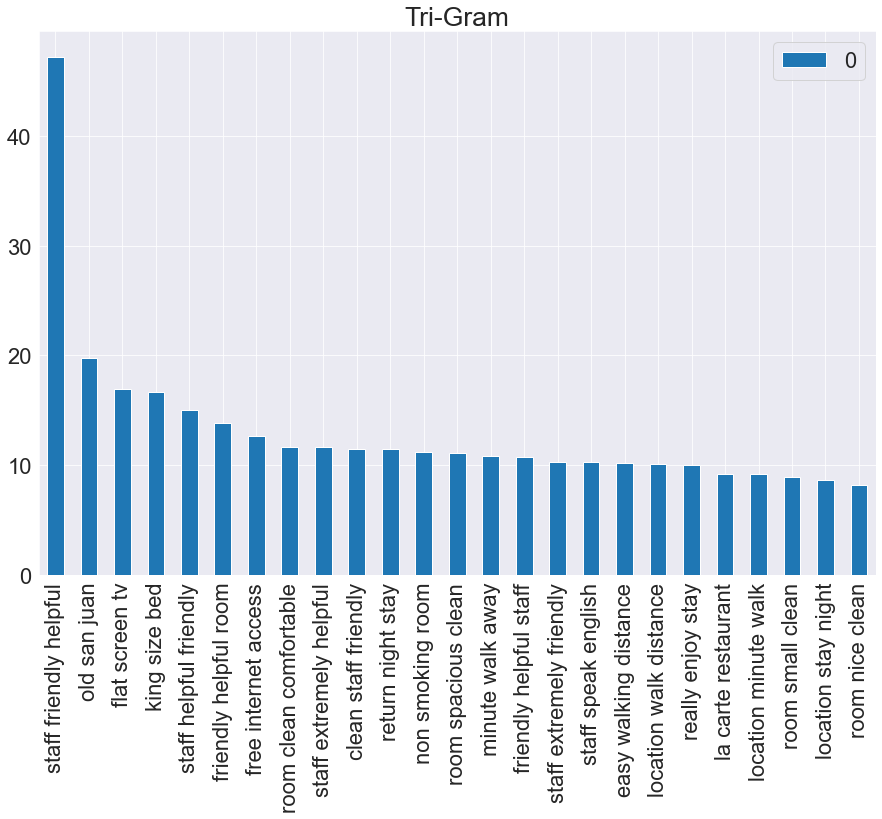

In [ ]:
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Tri-Gram', figsize=(15, 10))

### Important Attribute Extraction from the Reviews

##### CountVectorizer

In [ ]:
cv2 = CountVectorizer(stop_words=stop_words_keywords,ngram_range=(1,2))
cv2_x = cv2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(cv2_x)

# get feature names
feature_names = cv2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv2.transform([doc]))

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drinking terrece look light city barcelona offer stay go barcelona soccor match amazing definatly worth visit spend day fab tour bus pay e day ticket e day hop bus arounnd city fall love food market ramble main high street get smoothie euro packet fruit euro morning breakfast evening meal usually no dearer e starter main desert look special offer meal display door restaurant total barcelona fab city art buliding history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
barcelona 0.164
fab 0.111
usually dearer 0.101
total barcelona 0.101
terrece look 0.101
street smoothie 0.101
soccor match 0.101
soccor 0.101
smoothie euro 0.101
sand highly 0.101


#### TFIDG

In [ ]:
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,2))
tfidf2_x = tfidf2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(tfidf2_x)

# get feature names
feature_names = tfidf2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(tfidf2.transform([doc]))

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drinking terrece look light city barcelona offer stay go barcelona soccor match amazing definatly worth visit spend day fab tour bus pay e day ticket e day hop bus arounnd city fall love food market ramble main high street get smoothie euro packet fruit euro morning breakfast evening meal usually no dearer e starter main desert look special offer meal display door restaurant total barcelona fab city art buliding history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
usually dearer 0.118
total barcelona 0.118
terrece look 0.118
street smoothie 0.118
soccor match 0.118
soccor 0.118
smoothie euro 0.118
sand highly 0.118
recocommend 0.118
ramble main 0.118


### Feature extraction by converting text in vector by using TFIDF

In [ ]:
tfidf = TfidfVectorizer(max_features=3000,
                       ngram_range=(1,3))
# TFIDF for X-train
corpus_tfidf= tfidf.fit_transform(corpus)

# save the model to disk
filename = 'model_TFIDF.sav'
dump(tfidf, open('model_TFIDF.sav', 'wb'))

###  X and Y Variable

In [ ]:
# Creation of X and Y variable
X = corpus_tfidf
y = df['Affin_sentiment']

### Handling imbalanced data
**We will have to handling the imbalanced data set by using SMOTE Technique**

<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

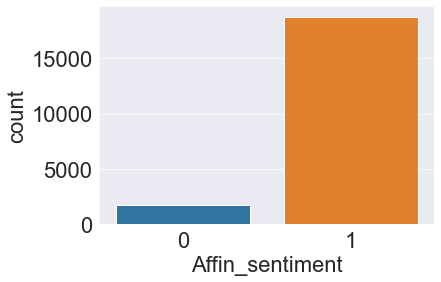

In [ ]:
# visualization of the imbalanced Y variable
sns.countplot(y)

In [ ]:
# the minority class will over sampled by 80%
stregegy = 0.8

# initializing of SMOTEN Sampling
over = SMOTE(sampling_strategy= stregegy,random_state=7)

In [ ]:
# Over Samplled X and Y variable 
X_over, y_over = over.fit_resample(X, y)

<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

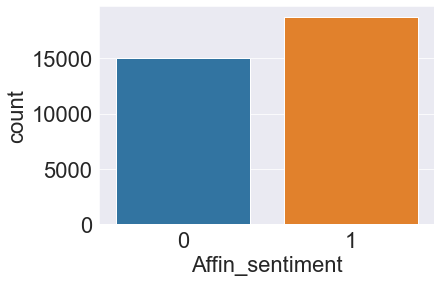

In [ ]:
sns.countplot(y_over)

### Split the Data into Train and Test

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_over, y_over,random_state=7,test_size=0.20,stratify=y_over)

In [ ]:
print("X_train = {}".format(X_train.shape))
print("X_test = {}".format(X_test.shape))
print("y_train = {}".format(y_train.shape))
print("y_test = {}".format(y_test.shape))

X_train = (27070, 3000)
X_test = (6768, 3000)
y_train = (27070,)
y_test = (6768,)


### Model Building

In [ ]:
# custom Fuction to run the model with confusion matrix + Train and test accuracy + F1score
def model_metric(X_train, X_test, y_train, y_test, model, name):

    # predicted for X_train and X_test
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)

    # Accuracy
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)

    # F1score
    f1_score = metrics.f1_score(y_train, predict_train)

    print('Accuracy for Train set {}'.format(accuracy_train))
    print('Accuracy for Test set {}'.format(accuracy_test))
    print('Fi Score {}'.format(f1_score))
    
    print(classification_report(y_test, predict_test))

    plot_confusion_matrix(estimator=model,
                          X=X_test,
                          y_true=y_test,
                          cmap='Blues')
    plt.grid(False)
    plt.title('{} - Confusion Matrix on Test set'.format(name))

#### Model 1 - Logistic Regression

In [ ]:
## from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV

# Grid Creation
Grid = dict()
Grid['C'] = (0.001, 0.01, 0.1, 0.18, 0.2, 1,5)
Grid['penalty'] = ("l1", "l2", "elasticnet")

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = LogisticRegression()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'C': 5, 'penalty': 'l2'}
Best Score - 0.9771702992242336


Accuracy for Train set 0.9903583302548947
Accuracy for Test set 0.9768026004728132
Fi Score 0.9912554025530204
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3008
           1       1.00      0.96      0.98      3760

    accuracy                           0.98      6768
   macro avg       0.98      0.98      0.98      6768
weighted avg       0.98      0.98      0.98      6768



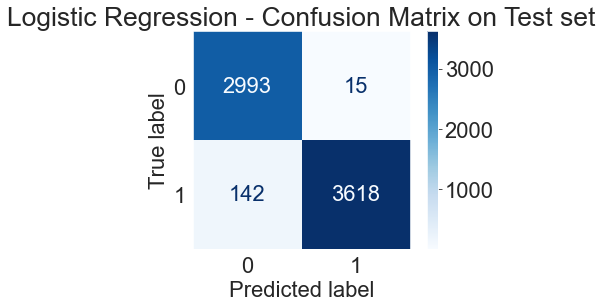

In [ ]:
# from sklearn.linear_model import LogisticRegression
name = 'Logistic Regression'
model_lr = LogisticRegression(C=5, penalty='l2', random_state=7)
model_lr.fit(X_train, y_train)

model_metric(X_train, X_test, y_train, y_test, model_lr,
                'Logistic Regression')

#### Model 2 - K-Nearest Neighbour

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# Grid Creation
Grid = dict()
Grid['n_neighbors'] = range(2,40)

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = KNeighborsClassifier()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'n_neighbors': 3}
Best Score - 0.47414111562615446


Accuracy for Train set 0.5082009604728481
Accuracy for Test set 0.47650709219858156
Fi Score 0.20590515955860425
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      3008
           1       1.00      0.06      0.11      3760

    accuracy                           0.48      6768
   macro avg       0.73      0.53      0.37      6768
weighted avg       0.76      0.48      0.34      6768



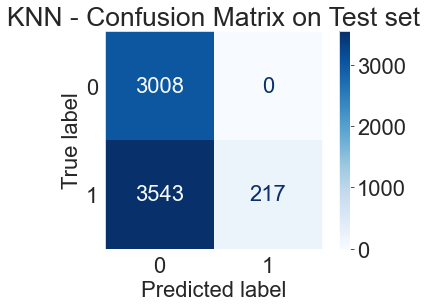

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_knn.fit(X_train, y_train)
model_metric(X_train, X_test, y_train, y_test, model_knn, 'KNN')

#### Model 3 - Random Forest 

In [ ]:
# Random forest algorithm for Classification
# from sklearn.ensemble import RandomForestClassifier

# Grid creation
Grid = dict()
Grid['n_estimators'] = (10, 100, 1000)
Grid['max_depth'] = (3, 7, 9, 15, 24)
Grid['max_features'] = ("auto", "sqrt", "log2")

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# define models
model = RandomForestClassifier()

# Setting Grid Search CV
search = GridSearchCV(model, Grid, cv=cv)

# Fitting tthe cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

In [ ]:
# define models and parameters
num_trees = 1000
model = RandomForestClassifier(n_estimators=num_trees, max_features='auto',max_depth=24)
model.fit(X_train, y_train)

#Results
model_metric(X_train,X_test,y_train,y_test,model, 'Random Forest')

#### Model 4 - Support Vector Classifier

In [ ]:
# Support Vector Classifier algorithm for Classification

# Grid creation
Grid = dict()
Grid['C'] = (0.1, 1, 10, 100, 1000)
Grid['gamma'] = (1, 0.1, 0.01, 0.001, 0.0001)

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# define models
model = SVC()

# Setting Grid Search CV
search = GridSearchCV(model, Grid, cv=cv)

# Fitting tthe cv to train and test
search.fit(X_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

In [ ]:
# Define model
model_svc = SVC(C=10, kernel='linear', gamma=100)
model_svc.fit(X_train, y_train)

#Results
model_metric(X_train, X_test, y_train, y_test, model_svc, "SVM")

#### Model 5 - Naive Bayes

In [ ]:
model_naive = MultinomialNB()
model_naive.fit(X_train, y_train)

#Results
model_metric(X_train, X_test, y_train, y_test, model_naive, "Naive Bayes")